# TODO:


* Visualize RGB State to Grayscale resized State
* action repeat Wrapper (4 Times)
* better reward handling for different games
* save REWARD_LIST to Disk
* load weight
* play game


In [1]:
import gym
import numpy as np

# **Auswahl des Spiels**

[Hier](https://gym.openai.com/envs/#atari) ist eine vollständige Liste der verfügbaren Spiele zu finden. Um ein Environment zu erstellen muss der vollständige Name des Spiels als String übergeben werden.

Beispiel:

```python
game = "MsPacman-v0"
```

In [2]:
# Hier kann das Spiel übergeben werden
game = "Breakout-v0"

# **Preprocessing**
[Stable Baselines](https://github.com/openai/baselines/blob/master/baselines/common/atari_wrappers.py)


### Fire Wrapper

In [3]:
class FireResetEnv(gym.Wrapper):
    def __init__(self, env):
        gym.Wrapper.__init__(self, env) 
        self.env.reset()

    def reset(self, **kwargs):
        self.env.reset(**kwargs)
        observation, _, _, _ = self.env.step(env.unwrapped.get_action_meanings().index('FIRE'))

        return observation

### Frame Stack Wrapper

In [4]:
from collections import deque

class FrameStack(gym.Wrapper):
    def __init__(self, env):
      super().__init__(env)
      self.frames = deque(maxlen=4)
      low = np.repeat(self.observation_space.low[np.newaxis, ...], repeats=4, axis=0)
      high = np.repeat(self.observation_space.high[np.newaxis, ...], repeats=4, axis=0)
      self.observation_space = gym.spaces.Box(low=low, high=high, dtype=self.observation_space.dtype)

    def step(self, action):
      obs, reward, done, info = self.env.step(action)
      self.frames.append(obs)
      frame_stack = np.asarray(self.frames, dtype=np.float32)
      frame_stack = np.moveaxis(frame_stack, 0, -1).reshape(1, 84, 84, -1)
      return frame_stack, reward, done, info

    def reset(self, **kwargs):
        obs = self.env.reset(**kwargs)
        for _ in range(4):
          self.frames.append(obs)
        frame_stack = np.asarray(self.frames, dtype=np.float32)
        frame_stack = np.moveaxis(frame_stack, 0, -1).reshape(1, 84, 84, -1)
        return frame_stack

### Resize & Grayscale Wrapper

Bild nicht Grauwert -> [stackoverflow](https://stackoverflow.com/questions/51303361/color-rgb2gray-gives-none-grayscale-image-might-be-an-issue-with-jupyter-notebo)
```python
cmap = "gray" # while plotting
```

In [5]:
from gym import spaces
import cv2

class WarpFrame(gym.ObservationWrapper):
    def __init__(self, env):
        """
        Warp frames to 84x84 as done in the Nature paper and later work.
        :param env: (Gym Environment) the environment
        """
        gym.ObservationWrapper.__init__(self, env)
        self.width = 84
        self.height = 84
        self.observation_space = spaces.Box(low=0, high=255, shape=(self.height, self.width, 1),
                                            dtype=env.observation_space.dtype)
        
    def observation(self, frame):
        """
        returns the current observation from a frame
        :param frame: ([int] or [float]) environment frame
        :return: ([int] or [float]) the observation
        """
        frame = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
        frame = cv2.resize(frame, (self.width, self.height), interpolation=cv2.INTER_AREA)
        return frame[:, :, None]

In [6]:
def make_env(env_name):
  env = gym.make(env_name)
  env = WarpFrame(env)
  if 'FIRE' in env.unwrapped.get_action_meanings():
    env = FireResetEnv(env)
  env = FrameStack(env)
  return env

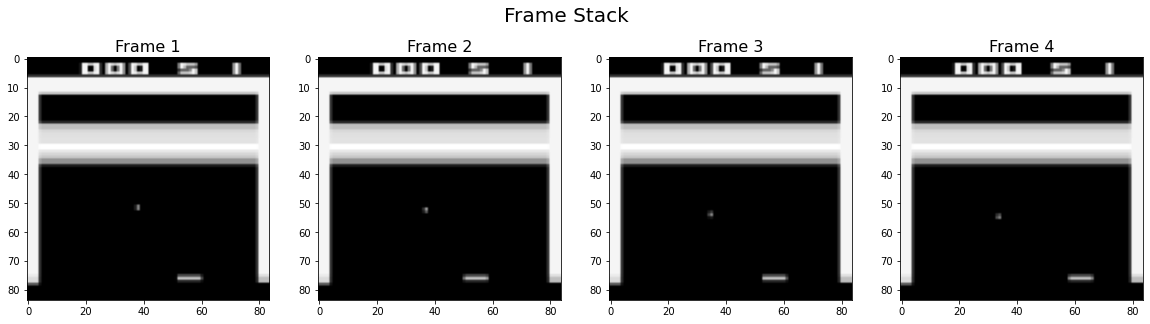

In [7]:
from matplotlib import pyplot as plt
import numpy as np

# Environment erstellen und auf Startzustand zurücksetzen
env = make_env(game)
env.reset()

for _ in range(1, 5):
  # Führe eine zufällige Aktion aus
  state, _, _, _ = env.step(env.action_space.sample())

# Stack umformen, damit das Plotten der vier Bilder gelingt
state = state.reshape(84, 84,4)

# Frame Stack plotten
fig, axs = plt.subplots(1,4, figsize=(20, 5))
fig.suptitle('Frame Stack', fontsize=20)
for i in range(state.shape[2]):
  axs[i].imshow(state[:, :, i], cmap="gray")
  axs[i].set_title("Frame "+str(i+1), fontsize=16)
plt.show()


# **Deep Q-Network und Target Network**

 *\"The input to
the neural network consists of an 84x84x4 image produced by the preprocessing
map **--w-- (falsche Darstellung)**. The first hidden layer convolves 32 filters of 8x8 with stride 4 with the
input image and applies a rectifier nonlinearity. The second hidden layer convolves
64 filters of 4x4 with stride 2, again followed by a rectifier nonlinearity.
This is followed by a third convolutional layer that convolves 64 filters of 333 with
stride 1 followed by a rectifier. The final hidden layer is fully-connected and consists
of 512 rectifier units. The output layer is a fully-connected linear layer with a
single output for each valid action. The number of valid actions varied between 4
and 18 on the games we considered."*


[Mnih, V., Kavukcuoglu, K., Silver, D. et al. Human-level control through deep reinforcement learning. Nature 518, 529–533 (2015).](https://www.nature.com/articles/nature14236)

In [8]:
import tensorflow as tf
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.losses import Huber
from tensorflow.keras.optimizers import RMSprop

# DQN und Tagret Net Parameters

INPUT_SHAPE = (84, 84, 4) # (Höhe, Breite, Frames)
OUTPUT_SHAPE = env.action_space.n # Anzahl der möglichen Aktionen
LOSS_FUNCTION = Huber()
OPTIMIZER = RMSprop(learning_rate=0.00025, rho=0.95, epsilon=0.01)

# Funktion zum erstellen eines neuronalen Netzes
def build_neural_net(INPUT_SHAPE, OUTPUT_SHAPE, LOSS_FUNCTION, OPTIMIZER):
  net_input = Input(shape=INPUT_SHAPE)
  x = Conv2D(filters=32, kernel_size=(8, 8), strides=(4, 4), padding="same")(net_input)
  x = Activation("relu")(x)
  x = Conv2D(filters=64, kernel_size=(4, 4), strides=(2, 2), padding="same")(x)
  x = Activation("relu")(x)
  x = Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), padding="same")(x)
  x = Activation("relu")(x)
  x = Flatten()(x)
  x = Dense(256)(x)
  x = Activation("relu")(x)
  net_output = Dense(OUTPUT_SHAPE)(x)

  model = Model(inputs=net_input, outputs=net_output)
  model.compile(loss=LOSS_FUNCTION, optimizer=OPTIMIZER)

  return model

# Deep Q-Network
DQN = build_neural_net(INPUT_SHAPE, OUTPUT_SHAPE, LOSS_FUNCTION, OPTIMIZER)
# Target Network
TARGET = build_neural_net(INPUT_SHAPE, OUTPUT_SHAPE, LOSS_FUNCTION, OPTIMIZER)

In [9]:
DQN.summary(), TARGET.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 84, 84, 4)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 21, 21, 32)        8224      
_________________________________________________________________
activation (Activation)      (None, 21, 21, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        32832     
_________________________________________________________________
activation_1 (Activation)    (None, 11, 11, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 11, 11, 64)        36928     
_________________________________________________________________
activation_2 (Activation)    (None, 11, 11, 64)       

(None, None)

# **Memory Buffer und Experience Replay**

In [10]:
MEMORY_SIZE = 1000000
MEMORY_BUFFER = deque(maxlen=MEMORY_SIZE)
TRAIN_START = 50000

# Speichert Transition von einem State in einen Folgestate
def save_transition(state, action, reward, next_state, done):
  MEMORY_BUFFER.append([state, action, reward, next_state, done])

In [11]:
import random
MINIBATCH_SIZE = 32
GAMMA = 0.99

def replay():

  # Ziehe 32 (MINIBATCH_SIZE) zufällige Transitionen aus dem Buffer in einen Minibatch
  minibatch = random.sample(MEMORY_BUFFER, MINIBATCH_SIZE)
  states, actions, rewards, next_states, dones = zip(*minibatch)

  states = np.concatenate(states)
  next_states = np.concatenate(next_states)

  q_values = DQN.predict(states)
  q_values_next = TARGET.predict(next_states)

  # Q-Values Update
  for i in range(MINIBATCH_SIZE):
    a = actions[i]
    done = dones[i]
    if done:
      q_values[i][a] = rewards[i]
    else:
      q_values[i][a] = rewards[i] + GAMMA * np.max(q_values_next[i])

  DQN.fit(states, q_values, verbose=0)

# **Aktion wählen**
Exploration & Exploitation

In [12]:
EPSILON = 1.0
EPSILON_MIN = 0.01
EPSILON_STEPS = 1000000

def get_action(state):
  if np.random.rand() <= EPSILON:
    return np.random.randint(env.action_space.n)
  else:
    return np.argmax(DQN(state))

# **Training des Agenten**

In [13]:
EPISODES = 30000
REWARD_LIST = []
BEST_MEAN_REWARD = 0.0
SYNC = 10000

for episode in range(EPISODES):
  EPISODE_REWARD = 0.0
  state = env.reset()
  done = False

  while not done:
    action = get_action(state)
    next_state, reward, done, _ = env.step(action)

    # Transition im MEMORY BUFFER speichern
    save_transition(state, action, reward, next_state, done)
    
    # Experience Replay, falls genügend Transitionen gespeichert
    if len(MEMORY_BUFFER) > TRAIN_START:
      replay()

    # Reward einer Aktion zum gesamten Reward der Episode addieren
    EPISODE_REWARD += reward

    # EPSILON verringern
    if len(MEMORY_BUFFER) > TRAIN_START:
      if EPSILON > EPSILON_MIN:
        EPSILON = EPSILON - ((EPSILON - EPSILON_MIN) / EPSILON_STEPS)

    # State aktualisieren
    state = next_state

    # Synchronisation zwischen Target Networks und Deep Q-Network
    if episode+1 % SYNC == 0:
      TARGET.set_weights(DQN.get_weights())

    if done:
      REWARD_LIST.append(EPISODE_REWARD)
      current_mean_reward = np.mean(REWARD_LIST[-min(len(REWARD_LIST), 10):])
      print("Episode:", episode+1, "\tReward:", EPISODE_REWARD, "\tMean:", round(current_mean_reward, 2), "\tTRAIN START:", (len(MEMORY_BUFFER)>TRAIN_START), "\tEpsi:", EPSILON)

      # Übernahme des höchsteb Mean Rewards
      if current_mean_reward > BEST_MEAN_REWARD:
        BEST_MEAN_REWARD = current_mean_reward
        
        # Trainierte Gewichte speichern
        if EPSILON < EPSILON_MIN:
          import os
          PATH = "WEIGHTS"
          try:
            os.makedirs(PATH)
          except FileExistsError:
            # Pfad existiert bereits
            pass
          DQN.save_weights(PATH +"/" + game + "_DQN"+ "_Ep_"+ str(episode+1)+ ".h5")
          TARGET.save_weights(PATH+"/" + game + "_TARGET" + "_Ep_"+ str(episode+1)+ ".h5")
      

Episode: 1 	Reward: 3.0 	Mean: 3.0 	TRAIN START: False 	Epsi: 1.0
Episode: 2 	Reward: 6.0 	Mean: 4.5 	TRAIN START: False 	Epsi: 1.0
Episode: 3 	Reward: 2.0 	Mean: 3.67 	TRAIN START: False 	Epsi: 1.0
Episode: 4 	Reward: 3.0 	Mean: 3.5 	TRAIN START: False 	Epsi: 1.0
Episode: 5 	Reward: 4.0 	Mean: 3.6 	TRAIN START: False 	Epsi: 1.0
Episode: 6 	Reward: 4.0 	Mean: 3.67 	TRAIN START: False 	Epsi: 1.0
Episode: 7 	Reward: 1.0 	Mean: 3.29 	TRAIN START: False 	Epsi: 1.0
Episode: 8 	Reward: 0.0 	Mean: 2.88 	TRAIN START: False 	Epsi: 1.0
Episode: 9 	Reward: 2.0 	Mean: 2.78 	TRAIN START: False 	Epsi: 1.0
Episode: 10 	Reward: 4.0 	Mean: 2.9 	TRAIN START: False 	Epsi: 1.0
Episode: 11 	Reward: 1.0 	Mean: 2.7 	TRAIN START: False 	Epsi: 1.0
Episode: 12 	Reward: 2.0 	Mean: 2.3 	TRAIN START: False 	Epsi: 1.0
Episode: 13 	Reward: 0.0 	Mean: 2.1 	TRAIN START: False 	Epsi: 1.0
Episode: 14 	Reward: 0.0 	Mean: 1.8 	TRAIN START: False 	Epsi: 1.0
Episode: 15 	Reward: 0.0 	Mean: 1.4 	TRAIN START: False 	Epsi: 1.0

KeyboardInterrupt: ignored